In [1]:
library(Signac)
library(Seurat)
library(EnsDb.Hsapiens.v86)
library(SeuratDisk)
library(dplyr)
library(BSgenome.Hsapiens.UCSC.hg38)

Warning message:
“package ‘Signac’ was built under R version 4.3.3”
Warning message:
“package ‘Seurat’ was built under R version 4.3.3”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.3.3”
Loading required package: sp

Warning message:
“package ‘sp’ was built under R version 4.3.3”

Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: ensembldb

Warning message:
“package ‘ensembldb’ was built under R version 4.3.2”
Loading required package: BiocGenerics

Warning message:
“package ‘BiocGenerics’ was built under R version 4.3.2”

Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
 

In [ ]:
ifnb <- readRDS("hc_rbd_pd_processed_atac.rds")

In [3]:
DefaultAssay(ifnb) <- "ATAC"
# first compute the GC content for each peak
ifnb <- RegionStats(ifnb, genome = BSgenome.Hsapiens.UCSC.hg38)

Warning message in RegionStats.default(object = regions, genome = genome, verbose = verbose, :
"Not all seqlevels present in supplied genome"


In [ ]:
idents.plot <- c('astrocytes','endothelia cells','excitatory neurons','inhibitory neurons','microglia','oligodendrocyte precursor cells','oligodendrocytes')
Idents(ifnb) <- idents.plot
# ifnb <- SortIdents(ifnb)

In [9]:
ifnb

An object of class Seurat 
286542 features across 87250 samples within 1 assay 
Active assay: ATAC (286542 features, 0 variable features)
 2 layers present: counts, data

In [ ]:
ifnb@meta.data

In [8]:
ifnb$batch <- sub("^(.*)_.*$", "\\1", Cells(ifnb))

In [ ]:
ifnb <- NucleosomeSignal(ifnb)
ifnb <- TSSEnrichment(ifnb)

Extracting TSS positions

Extracting fragments at TSSs

Warning message in cc + as.vector(x = counts.center):
"longer object length is not a multiple of shorter object length"
Warning message in cc[names(x = counts.center)] <- cc + as.vector(x = counts.center):
"number of items to replace is not a multiple of replacement length"
Warning message in fc + as.vector(x = counts.flank):
"longer object length is not a multiple of shorter object length"
Warning message in fc[names(x = counts.flank)] <- fc + as.vector(x = counts.flank):
"number of items to replace is not a multiple of replacement length"
Warning message in cc + as.vector(x = counts.center):
"longer object length is not a multiple of shorter object length"
Warning message in cc[names(x = counts.center)] <- cc + as.vector(x = counts.center):
"number of items to replace is not a multiple of replacement length"
Warning message in fc + as.vector(x = counts.flank):
"longer object length is not a multiple of shorter object length"
War

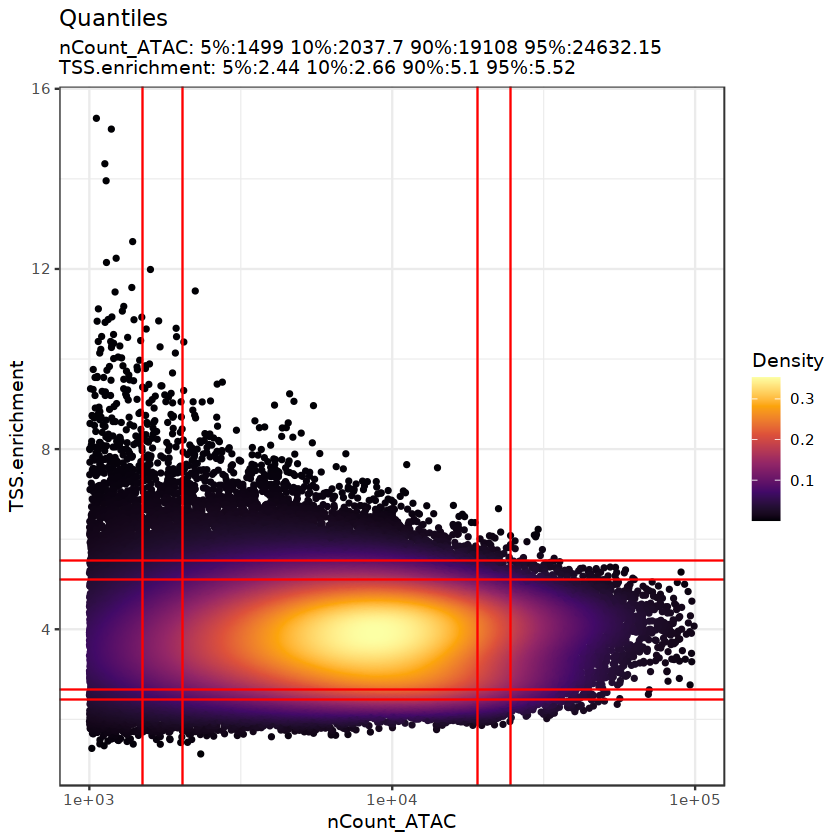

In [ ]:
DensityScatter(ifnb, x = 'nCount_ATAC', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



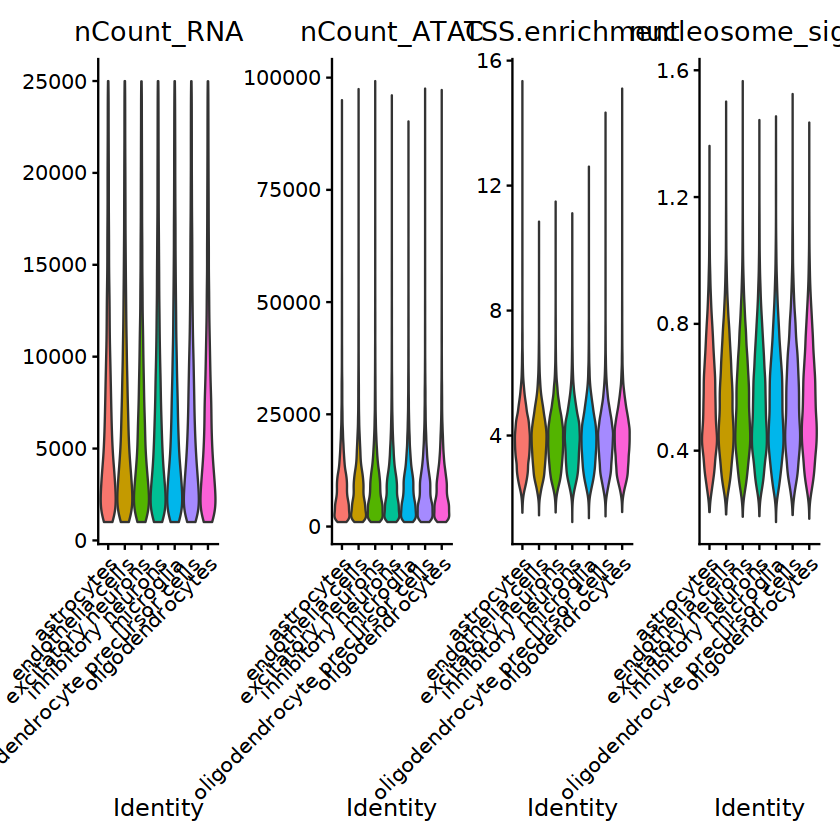

In [ ]:
VlnPlot(
  object = ifnb,
  features = c("nCount_RNA", "nCount_ATAC", "TSS.enrichment", "nucleosome_signal"),
  ncol = 4,
  pt.size = 0
)

In [10]:
# assume your object is called `obj`
DefaultAssay(ifnb) <- "ATAC"

# 1) Feature selection + normalization for ATAC
ifnb <- FindTopFeatures(ifnb, min.cutoff = "q0.9")   # use all peaks (or "q0.9" to keep top 10%)
ifnb <- RunTFIDF(ifnb)

# 2) LSI (skip the first component downstream; it often captures depth)
ifnb <- RunSVD(ifnb, n = 50, reduction.name = "lsi")

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, layer = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings



In [11]:
library(harmony)
ifnb <- RunHarmony(
  object        = ifnb,
  group.by.vars = "batch",
  reduction.use     = "lsi",
  assay.use     = "ATAC",
  project.dim = FALSE
)

Warning message:
"package 'harmony' was built under R version 4.3.3"
Loading required package: Rcpp

Warning message:
"package 'Rcpp' was built under R version 4.3.3"
Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony converged after 6 iterations



In [12]:
ifnb <- RunUMAP(
  ifnb, reduction = "harmony", dims = 2:20,
  n.neighbors = 150,
  min.dist    = 0.3,
  spread      = 0.6,
  seed.use    = 384,
  reduction.name = "umap_tighter", reduction.key = "UMAPt_"
)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
06:26:57 UMAP embedding parameters a = 2.279 b = 1.334

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

06:26:57 Read 87250 rows and found 19 numeric columns

06:26:57 Using Annoy for neighbor search, n_neighbors = 150

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

06:26:57 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

06:27:06 Writing NN index file to 

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



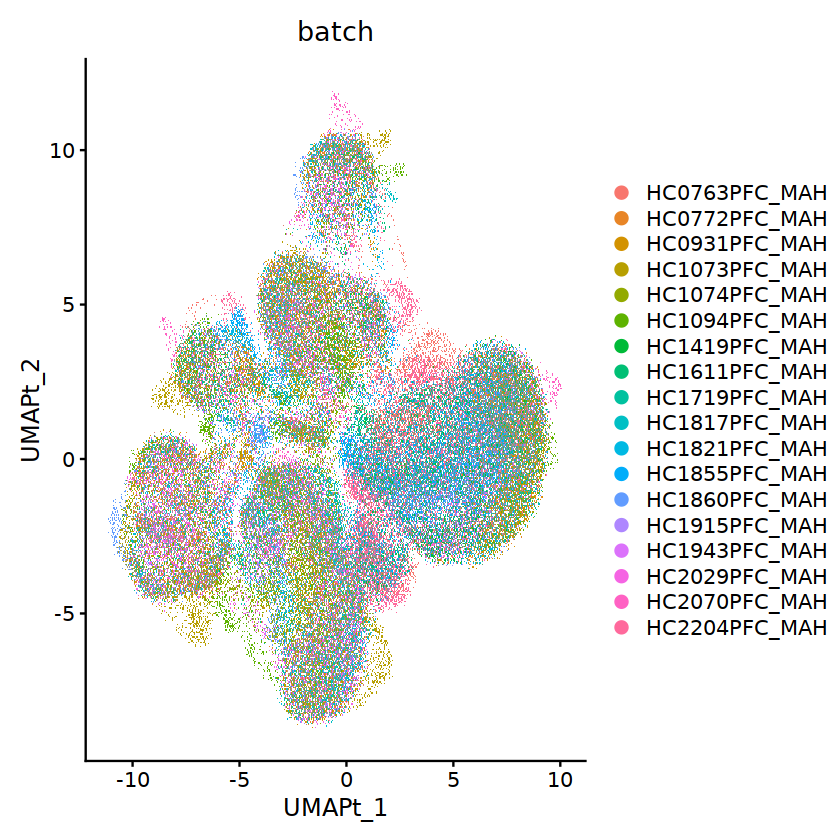

In [10]:
# after batch integration
DimPlot(ifnb, reduction = "umap_tighter", group.by = "batch")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



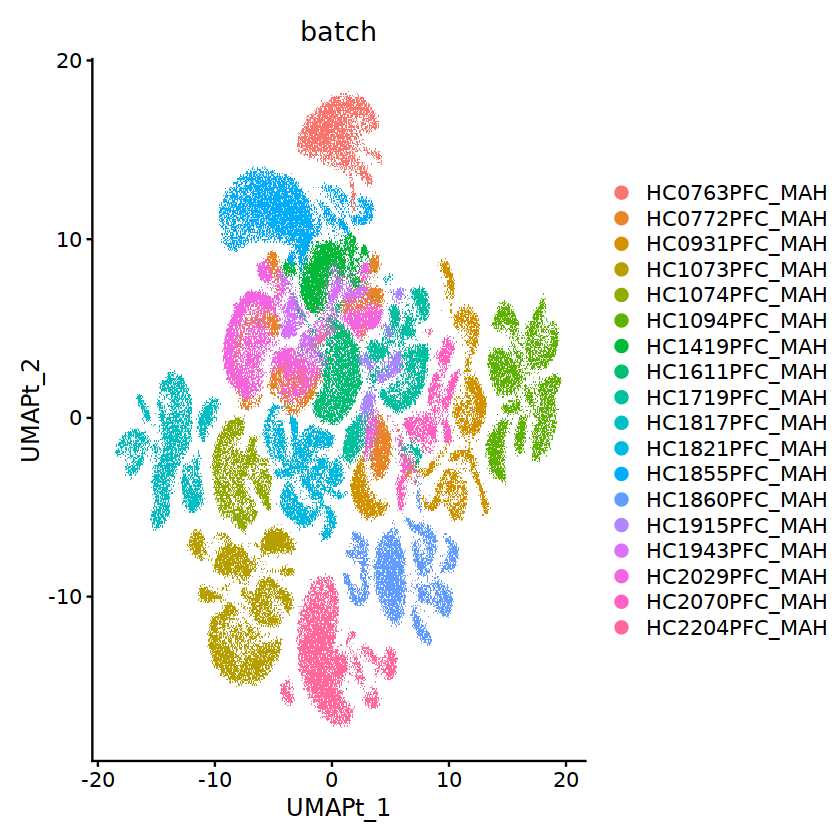

In [14]:
# before batch integration
DimPlot(ifnb, reduction = "umap_tighter", group.by = "batch")

Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'RColorBrewer' was built under R version 4.3.3"


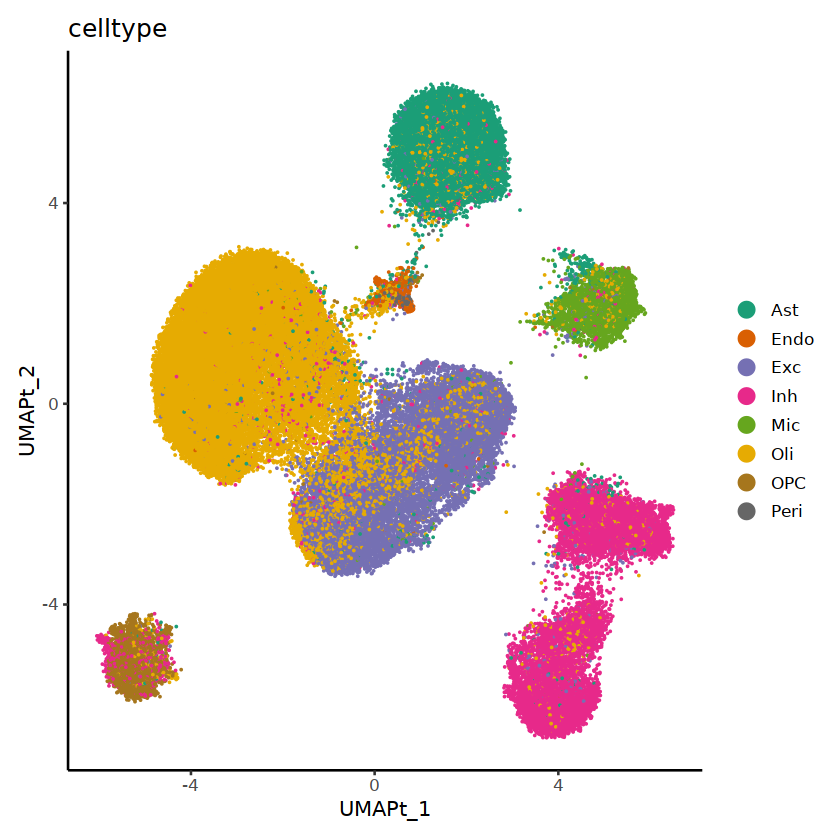

In [ ]:
library(Seurat)
library(Signac)
library(ggplot2)
library(RColorBrewer)

# --- desired order + labels ---
desired_levels <- c(
  "astrocytes",
  "endothelia cells",
  "excitatory neurons",
  "inhibitory neurons",
  "microglia",
  "oligodendrocytes",
  "oligodendrocyte precursor cells",
  "pericytes"
)

abbr_map <- c(
  "astrocytes" = "Ast",
  "endothelia cells" = "Endo",
  "excitatory neurons" = "Exc",
  "inhibitory neurons" = "Inh",
  "microglia" = "Mic",
  "oligodendrocytes" = "Oli",
  "oligodendrocyte precursor cells" = "OPC",
  "pericytes" = "Peri"
)

# Make sure 'celltype' is the active ident and ordered
Idents(ifnb) <- "celltype"
ifnb$celltype <- factor(ifnb$celltype, levels = desired_levels)
present_levels <- levels(droplevels(ifnb$celltype))  # those actually present

# Dark2 palette (8 colors) mapped to your order; subset to present levels
pal_dark2 <- setNames(brewer.pal(8, "Dark2"), desired_levels)
pal_use   <- pal_dark2[present_levels]

# --- plot ---
p <- DimPlot(
  ifnb, reduction = "umap_tighter", group.by = "celltype",
  pt.size = 0.01, shuffle = TRUE
) +
  scale_color_manual(
    values = pal_use,
    breaks = present_levels,
    labels = abbr_map[present_levels]
  ) +
  guides(color = guide_legend(title = NULL, override.aes = list(size = 4))) +
  theme_classic(base_size = 12)

print(p)

# Save to PDF
ggsave("../../man_figs_pdf/allct_umap_atac.pdf", plot = p,
       width = 6, height = 5, device = "pdf")

In [ ]:
pdf("../../man_figs_pdf/all_celltype_atac_umap_disease.pdf", width = 16, height = 16)
custom_colors <- c("#00BA38", "#F8766D", "#619CFF")
DimPlot(ifnb, reduction = "umap_tighter", group.by = c("disease"), alpha=0.5, cols = custom_colors, pt.size = 0.1, raster=FALSE)
dev.off()

png 
  2